# 1. 构建单决策树
# 2. 构建随机森林
# 3. 自动调参
# 4. 使用优化后的参数构建随机森林

# 指定参数构建单决策树

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
 
%matplotlib inline

In [14]:
from sklearn.datasets.california_housing import fetch_california_housing
housing = fetch_california_housing()
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [15]:
housing.data.shape

(20640, 8)

In [16]:
housing.data[0]

array([   8.3252    ,   41.        ,    6.98412698,    1.02380952,
        322.        ,    2.55555556,   37.88      , -122.23      ])

In [5]:
from sklearn import tree # 导入指定模块
dtr = tree.DecisionTreeRegressor(max_depth=2) # 定义一个决策树，指定该树最大深度为2（其他参数配置见文档）
dtr.fit(housing.data[:, [6, 7]], housing.target) # （x，y）  housing.data[:, [6, 7]]是所有房价的第6、7列即经纬度，housing.target就是房价就是label标签

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [6]:
# https://graphviz.gitlab.io/_pages/Download/Download_windows.html 安装graphviz
# 安装完成后将graphviz加到环境变量中如D:\development\Graphviz\bin\ ，然后执行dot -c不加环境变量执行命令会报错,不执行命令后面会报错Format: “png” not recognized. Use one of:
# 加了环境变量，代码中也得加：
import os
os.environ["PATH"] += os.pathsep + 'D:/development/Graphviz/bin/'  

dot_data = tree.export_graphviz(dtr,        # dtr是上面定义的决策树名字
                                out_file=None,
                                feature_names=housing.feature_names[6:8], # 还需要指定特征名，打印时候用的
                                filled=True,
                                impurity=False,
                                rounded=True)

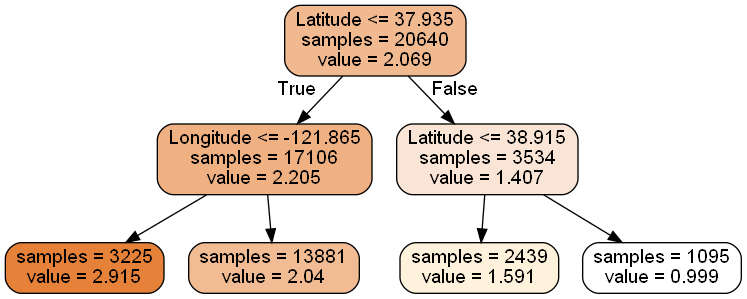

In [7]:
# 还要安装 pydotplus:     pip install pydotplus
import pydotplus
 
graph = pydotplus.graph_from_dot_data(dot_data)
graph.get_nodes()[7].set_fillcolor("#FFF2DD")
from IPython.display import Image
Image(graph.create_png())

In [8]:
from sklearn.model_selection import train_test_split
# 上面fit直接将所有数据都喂给了模型，下面切分训练集和测试集，用训练集训练用测试集测试。
# test_size=0.1是取10%作为测试集     random_state=42是随机种子，只要种子一样那么随机的10%就都是那10%
data_train, data_test, target_train, target_test = train_test_split(housing.data, housing.target, test_size=0.1, random_state=42)
dtr = tree.DecisionTreeRegressor(random_state=42)
dtr.fit(data_train, target_train)
 
dtr.score(data_test, target_test) # score是sklearn内部计算误差，好像是均方误差吧

0.637355881715626

# 基本的随机森林

In [11]:
from sklearn.ensemble import RandomForestRegressor # Regressor 回归
# random_state就是为了保证程序每次运行都分割一样的训练集和测试集
rfr = RandomForestRegressor( random_state = 42)
rfr.fit(data_train, target_train)
rfr.score(data_test, target_test)

0.8097021394052101

# 使用GridSearchCV自动调参

In [12]:
# from sklearn.grid_search import GridSearchCV
# sklearn.grid_search模块在0.18版本中被弃用，它所支持的类转移到model_selection模块中。还要注意，
# 新的CV迭代器的接口与这个模块的接口不同。sklearn.grid_search将在0.20中被删除。
from sklearn.model_selection import GridSearchCV   # GridSearchCV是sklearn 自动调参
tree_param_grid = {'min_samples_split':list((3,6)),'n_estimators':list((50,100))}   # 人工告诉决策树几个候选方案
 
grid = GridSearchCV(RandomForestRegressor(),param_grid=tree_param_grid,cv=2)   # cv 交叉验证，一般设为5，设为10也可以。交叉验证只切分训练集。
grid.fit(data_train,target_train)
# grid_scores_在sklearn0.20版本中已被删除，取而代之的是cv_results_。
grid.cv_results_, grid.best_params_, grid.best_score_

({'mean_fit_time': array([1.97507453, 3.95350683, 1.84549701, 3.70488465]),
  'std_fit_time': array([0.01119995, 0.03444779, 0.01583421, 0.02145112]),
  'mean_score_time': array([0.0625025 , 0.14062667, 0.05468893, 0.1177206 ]),
  'std_score_time': array([3.57627869e-07, 4.76837158e-07, 7.81345367e-03, 8.34465027e-03]),
  'param_min_samples_split': masked_array(data=[3, 3, 6, 6],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_n_estimators': masked_array(data=[50, 100, 50, 100],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'min_samples_split': 3, 'n_estimators': 50},
   {'min_samples_split': 3, 'n_estimators': 100},
   {'min_samples_split': 6, 'n_estimators': 50},
   {'min_samples_split': 6, 'n_estimators': 100}],
  'split0_test_score': array([0.78907611, 0.79074872, 0.78935924, 0.78975793]),
  'split1_test_score': array([0.79385322, 0.79440804, 0.79

# 使用优化后参数来构建随机森林

In [10]:
rfr = RandomForestRegressor( min_samples_split=3,n_estimators = 100,random_state = 42)
rfr.fit(data_train, target_train)
rfr.score(data_test, target_test)

0.8088623476993486